In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms
from minimal.walls import create_sep_mask, scale_sep_mask

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

In [3]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_05.pth"))
rooms = extract_rooms(pm)
rooms.sort(key=lambda r: r.total_area())
# blit_rooms(rooms)

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.4 s


In [4]:
room_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))
sep_mask = create_sep_mask(room_mask)

In [5]:
scaled_sep_mask = scale_sep_mask(sep_mask, 3, 3)
# blit_rooms(rooms, scaled_sep_mask, out_size=1024)

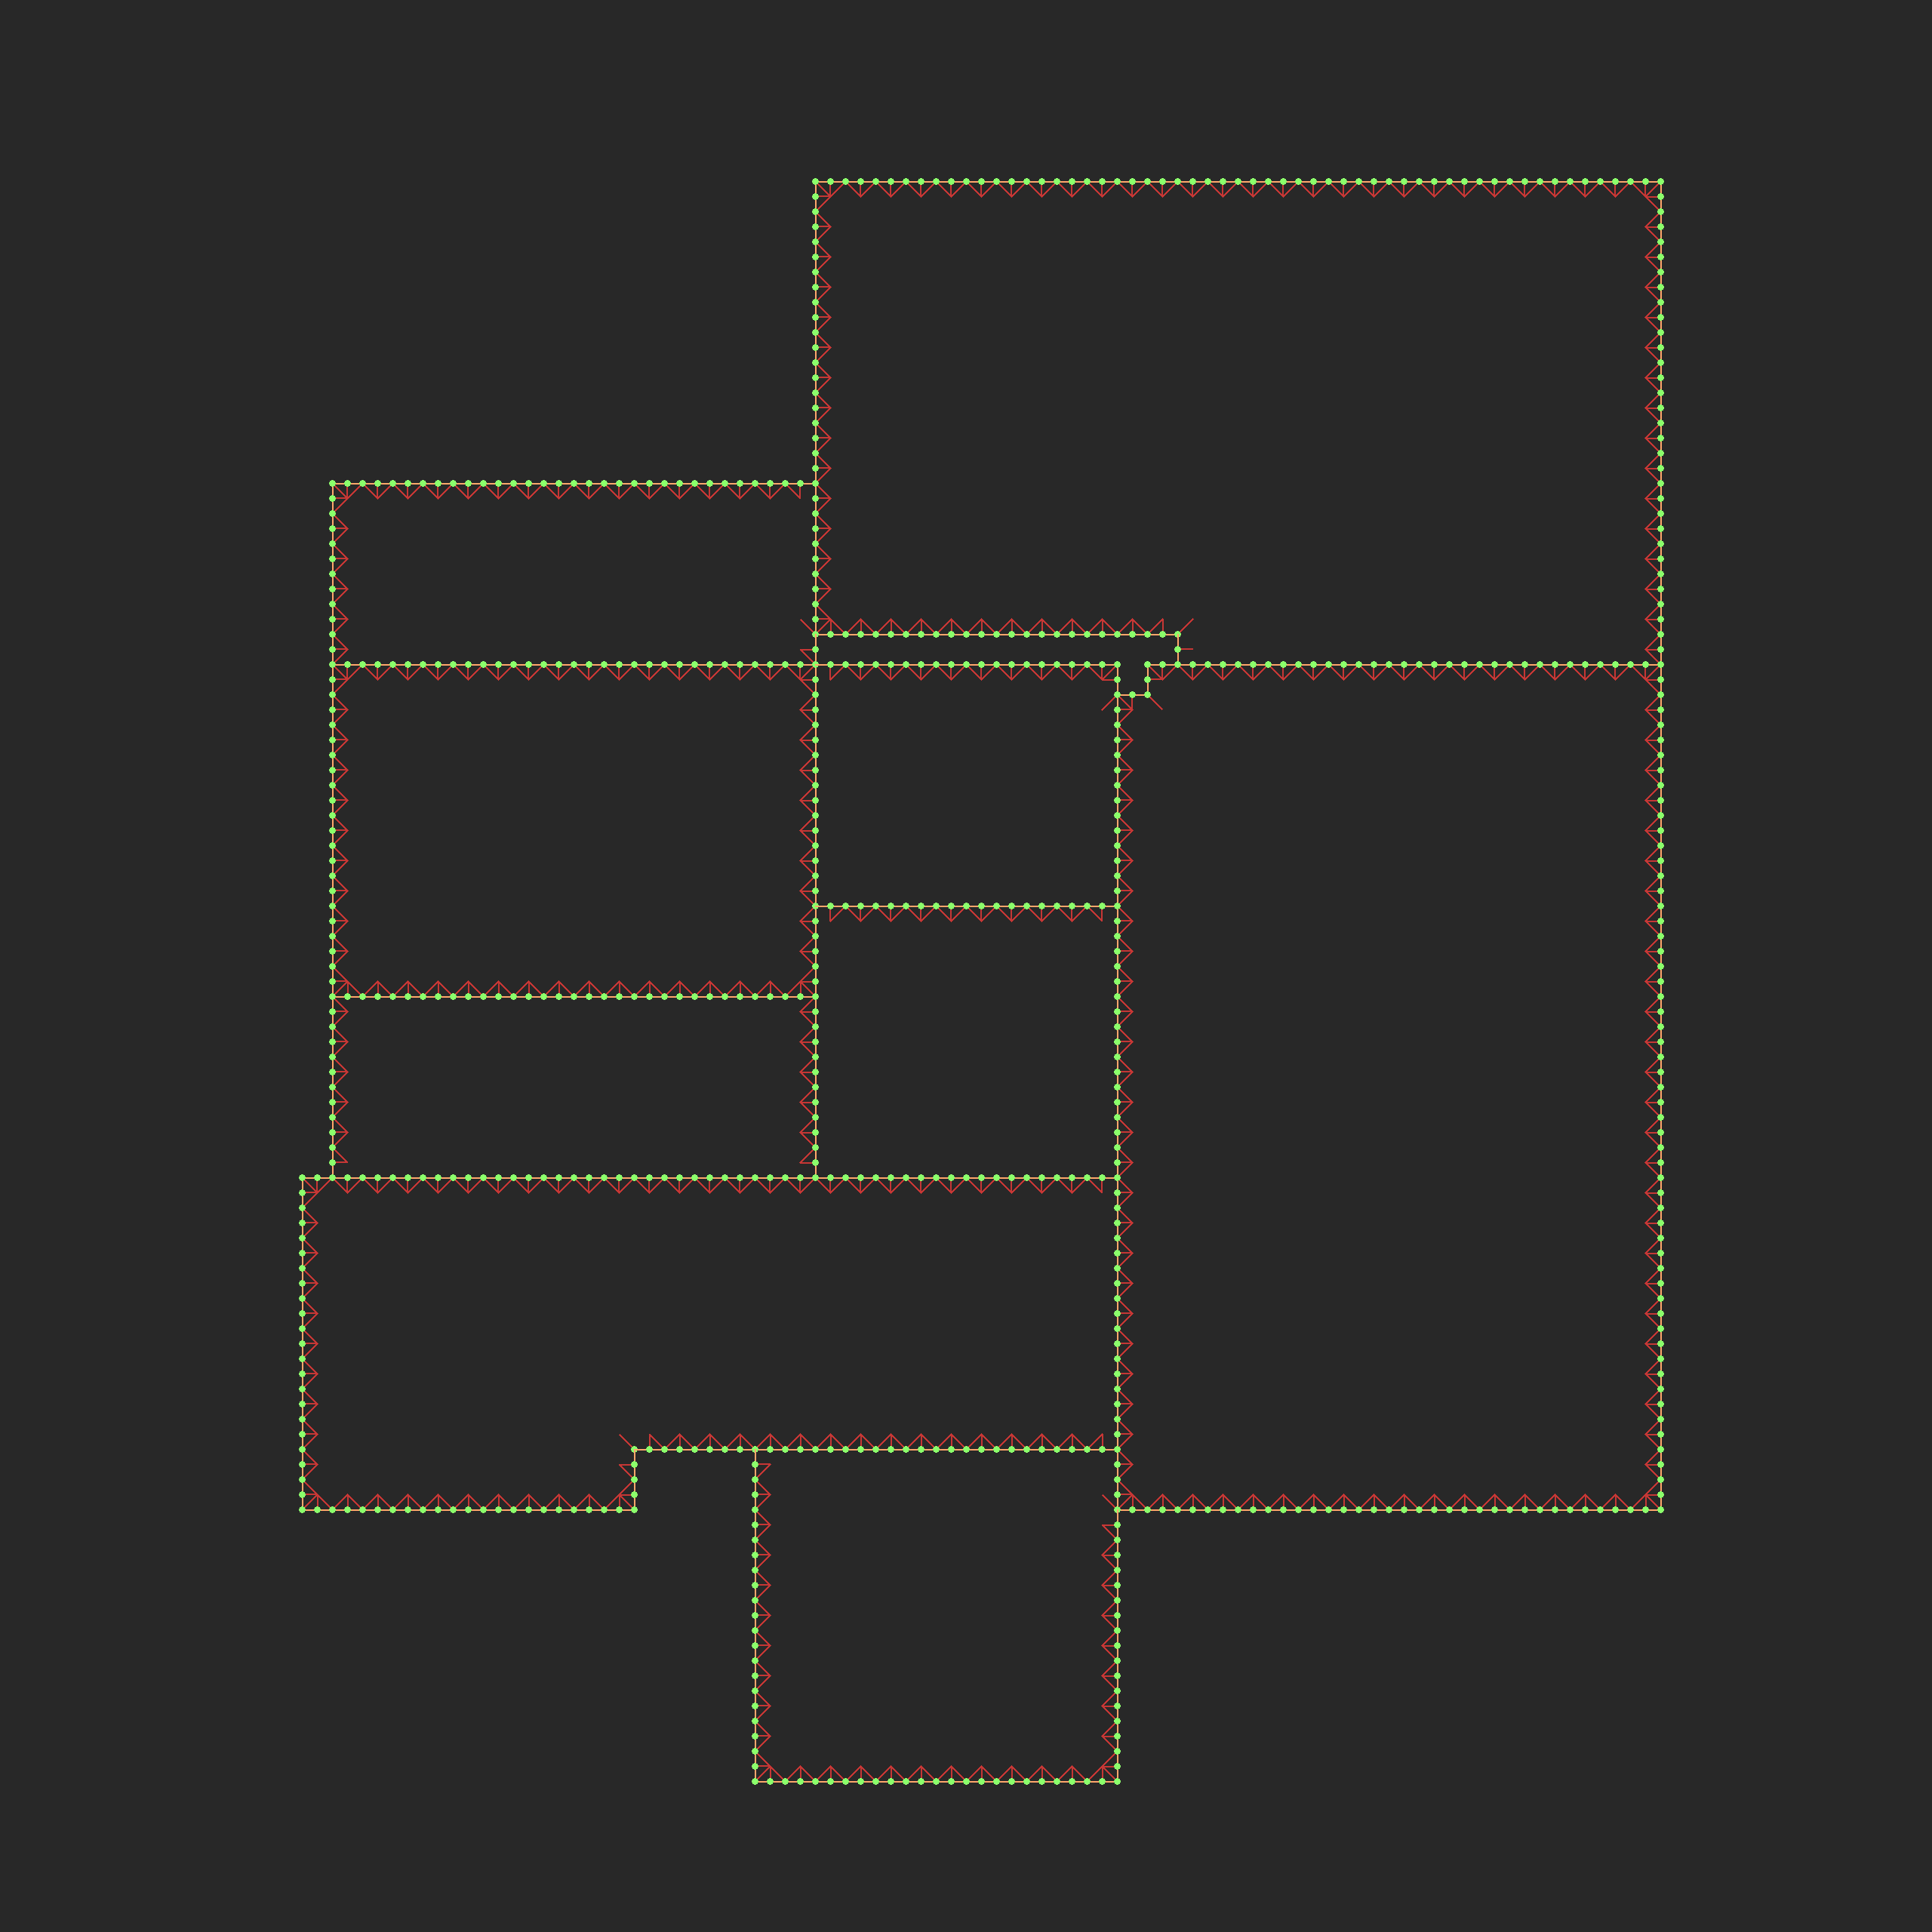

In [63]:
visualize_mask(sep_mask)

In [62]:
def visualize_mask(mask: torch.Tensor, cell_size: int = 40, dot_radius: int = 4):
    # Constants
    bg_color = "#282828"
    dot_color = "#8BFF6B"
    edge_line_color = "#FFA66B"
    center_line_color = "#C63735"

    len_x, len_y = mask.shape
    img_size = (len_y * cell_size, len_x * cell_size)

    img = Image.new("RGB", img_size, bg_color)
    draw = ImageDraw.Draw(img)

    # Iterate over the mask positions
    for x in range(len_x):
        for y in range(len_y):
            cell_x = y * cell_size
            cell_y = x * cell_size
            center = (cell_x + cell_size // 2, cell_y + cell_size // 2)

            # Read the bitmask value for this cell
            cell_value = mask[x, y].item()

            # Define positions for dots
            positions = {
                CC_TL: (cell_x, cell_y),  # Top-left
                CC_TR: (cell_x + cell_size, cell_y),  # Top-right
                CC_BR: (cell_x + cell_size, cell_y + cell_size),  # Bottom-right
                CC_BL: (cell_x, cell_y + cell_size),  # Bottom-left
                CC_T: (cell_x + cell_size // 2, cell_y),  # Top edge (middle)
                CC_R: (cell_x + cell_size, cell_y + cell_size // 2),  # Right edge (middle)
                CC_B: (cell_x + cell_size // 2, cell_y + cell_size),  # Bottom edge (middle)
                CC_L: (cell_x, cell_y + cell_size // 2),  # Left edge (middle)
            }

            # Draw edge connections between corners first (so dots render on top)
            if cell_value & CC_T:  # Top edge
                draw.line([positions[CC_TL], positions[CC_TR]], fill=edge_line_color, width=2)
            if cell_value & CC_R:  # Right edge
                draw.line([positions[CC_TR], positions[CC_BR]], fill=edge_line_color, width=2)
            if cell_value & CC_B:  # Bottom edge
                draw.line([positions[CC_BL], positions[CC_BR]], fill=edge_line_color, width=2)
            if cell_value & CC_L:  # Left edge
                draw.line([positions[CC_TL], positions[CC_BL]], fill=edge_line_color, width=2)

            # Draw dots and lines to center
            for bit, pos in positions.items():
                if cell_value & bit:
                    draw.line([center, pos], fill=center_line_color, width=2)
                    draw.ellipse(
                        (pos[0] - dot_radius, pos[1] - dot_radius, pos[0] + dot_radius, pos[1] + dot_radius),
                        fill=dot_color,
                        # outline="white"
                    )

    return img
